<h1><b>Introduction</b></h1>
<p>Hypoxia, a state of reduced oxygen in the tumour environment, is known to promote cancer progression and resistance to treatment. Thus, it is imperative to be able to identify hypoxic cells and their genetic markers, to implement targeted treatments. The goal of this project is to identify patterns and biomarkers linked to hypoxic cells and build a classifier that can identify whether a cell is hypoxic or normal.</p>

<p>Our first goal will be to pre-process the datasets, making sure that we have a high-quality, consistent data set that can be used to train a model. Next, we will conduct exploratory data analysis, to give us a better understanding of the data we are working with. After this, we will use unsupervised learning techniques (PCA and clustering) to uncover patterns and correlations between the hypoxic cells and the normal cells. Finally, we will train models on the data to build a robust classifier able to differentiate between normal and hypoxic cells.</p>

**N.B.** 
*As the data used for this project is classified, we have used placeholders where specific genetic markers were mentioned (e.g. Feature 1, Feature 2, etc.).*


<h1><b>Materials and Methods</b></h1>

<h2>Data Collection and Preprocessing</h2>
<p>In this study, we analyzed four datasets, which, for the purposes of not disclosing private information we will call Dataset_1, Dateset_2, Dataset_3, and Dataset_4. Each dataset underwent thorough preprocessing to ensure data quality. To understand the data distribution, we used violin plots which revealed significant skewness. Applying a log2 transformation helped reduce this skewness and stabilize variance.</p>

<h2>Exploratory Data Analysis (EDA)</h2>
<p>We conducted exploratory data analysis to delve into the structure and content of the datasets. This included checking the dimensions, data types, and value distributions. Correlation analysis was essential in identifying patterns and redundancies within the data. Using hierarchical clustering and elbow plots, we determined the optimal number of clusters, which confirmed the presence of distinct groups within each dataset.</p>

<h2>Dimensionality Reduction</h2>
<p>To handle the high dimensionality of the gene expression data, we employed Principal Component Analysis (PCA). This technique reduced the number of features while retaining most of the variance. We selected the number of principal components based on explained variance and elbow plots, ensuring that the reduced datasets were still representative.</p>

<h2>Model Training and Evaluation</h2>
<p>We trained three types of models: K-means clustering, Logistic Regression, and XGBoost classifiers. For K-means, we identified clusters based on the results of hierarchical clustering. Logistic Regression models were optimized using GridSearchCV to find the best regularization parameters. XGBoost models were trained with specific hyperparameters to maximize performance. We evaluated the models using accuracy.</p>

<h2>Multilayer Perceptron (MLP) Training</h2>
<p>We developed an MLP model for each dataset using PyTorch. After splitting the datasets into training and testing sets (while maintaining class balance), we defined an MLP architecture with multiple hidden layers, ReLU activation, and dropout for regularization. We trained the models using the Adam optimizer and monitored their performance through accuracy, precision, and recall.</p>

<h2>Predictions</h2>
<p>For making predictions on test data, we utilized the trained models. We applied PCA to the test datasets where necessary and used the trained models to generate predictions. The results were saved as CSV files for further analysis.</p>

Importing the libraries and data:

In [5]:
import torch
from sklearn.metrics import precision_score, recall_score
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
sns.set(color_codes=True)

In [6]:
filepath = "/filepath/"


#Dataset_2
df2_filt_norm = pd.read_csv(f"{filepath}/.txt",delimiter="\ ",engine='python',index_col=0)
df2_filt = pd.read_csv(f"{filepath}.txt",delimiter="\ ",engine='python',index_col=0)
df2_unfilt = pd.read_csv(f"{filepath}.txt",delimiter="\ ",engine='python',index_col=0)
df2_test = pd.read_csv(f"{filepath}.txt",delimiter="\ ",engine='python',index_col=0)

# N.B. the delimiters of course depend on your data file

Since we are dealing with a confidential dataset, we will rename the indices (genes) and columns (cells):

In [98]:
def rename(df):
    df.index = [f'Gene {i+1}' for i in range(len(df.index))]
    # Renaming the columns based on the original name containing 'Hypo' or 'Norm'
    new_columns = []
    for i, col in enumerate(df.columns):
        if 'Hypo' in col:
            new_columns.append(f'Cell {i+1} Hypo')
        elif 'Norm' in col:
            new_columns.append(f'Cell {i+1} Norm')
        else:
            new_columns.append(f'Cell {i+1}')
    df.columns = new_columns



In [99]:
rename(df2_filt_norm), rename(df2_filt), rename(df2_unfilt)

(None, None, None)

In [101]:
df2_unfilt.head()

,Cell 1 Norm,Cell 2 Norm,Cell 3 Hypo,Cell 4 Hypo,Cell 5 Hypo,Cell 6 Hypo,Cell 7 Hypo,Cell 8 Hypo,Cell 9 Norm,Cell 10 Norm,...,Cell 234 Norm,Cell 235 Hypo,Cell 236 Hypo,Cell 237 Hypo,Cell 238 Norm,Cell 239 Norm,Cell 240 Norm,Cell 241 Hypo,Cell 242 Norm,Cell 243 Norm
Gene 1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Gene 2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Gene 3,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Gene 4,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,1,0,0
Gene 5,2,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [102]:
print("Dataset_ dimensions:", np.shape(df2_unfilt))
print("First column: ", df2_unfilt.iloc[ : , 0])

Dataset_ dimensions: (23396, 243)
First column:  Gene 1           0
Gene 2           0
Gene 3           0
Gene 4           0
Gene 5           2
              ... 
Gene 23392      22
Gene 23393    4208
Gene 23394      26
Gene 23395      66
Gene 23396       0
Name: Cell 1 Norm, Length: 23396, dtype: int64


We confirm that there is no cell with all null entries:

In [103]:
df2_unfilt.isnull().sum().notnull().all()

True

In [104]:
df2_unfilt.describe()

,Cell 1 Norm,Cell 2 Norm,Cell 3 Hypo,Cell 4 Hypo,Cell 5 Hypo,Cell 6 Hypo,Cell 7 Hypo,Cell 8 Hypo,Cell 9 Norm,Cell 10 Norm,...,Cell 234 Norm,Cell 235 Hypo,Cell 236 Hypo,Cell 237 Hypo,Cell 238 Norm,Cell 239 Norm,Cell 240 Norm,Cell 241 Hypo,Cell 242 Norm,Cell 243 Norm
count,23396.000000,23396.000000,23396.000000,23396.000000,23396.000000,23396.000000,23396.000000,23396.000000,23396.000000,23396.000000,...,23396.000000,23396.000000,23396.000000,23396.000000,23396.000000,23396.000000,23396.000000,23396.000000,23396.000000,23396.000000
mean,99.565695,207.678278,9.694734,150.689007,35.700504,47.088434,152.799453,135.869422,38.363908,45.512139,...,76.361771,105.566593,54.026116,29.763806,28.905411,104.740725,35.181569,108.197940,37.279962,76.303855
std,529.532443,981.107905,65.546050,976.936548,205.885369,545.367706,864.974182,870.729740,265.062493,366.704721,...,346.659348,536.881574,344.068304,186.721266,135.474736,444.773045,170.872090,589.082268,181.398951,369.090274
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,1.000000
75%,51.000000,125.000000,5.000000,40.000000,22.000000,17.000000,81.000000,76.000000,22.000000,18.000000,...,56.000000,67.000000,29.000000,18.000000,19.000000,76.000000,24.000000,68.000000,22.000000,44.000000
max,35477.000000,69068.000000,6351.000000,70206.000000,17326.000000,47442.000000,43081.000000,62813.000000,30240.000000,35450.000000,...,19629.000000,30987.000000,21894.000000,13457.000000,11488.000000,33462.000000,15403.000000,34478.000000,10921.000000,28532.000000


We see from mean and standard deviation that the data is not normalized 

<AxesSubplot:xlabel='Cell 3 Hypo'>

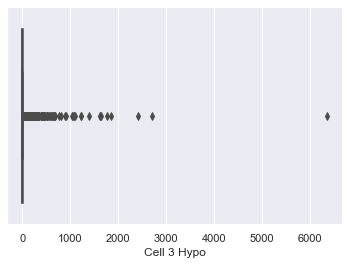

In [106]:
cnames1 = list(df2_unfilt.columns)
sns.boxplot(x=df2_unfilt[cnames1[2]])

In [107]:
print(min(df2_unfilt[cnames1[2]]))

0


As we can see by the median, which is zero, the distribution is skewed. However, this is the observation for only two cells, to make a more general observation, we preform further tests.

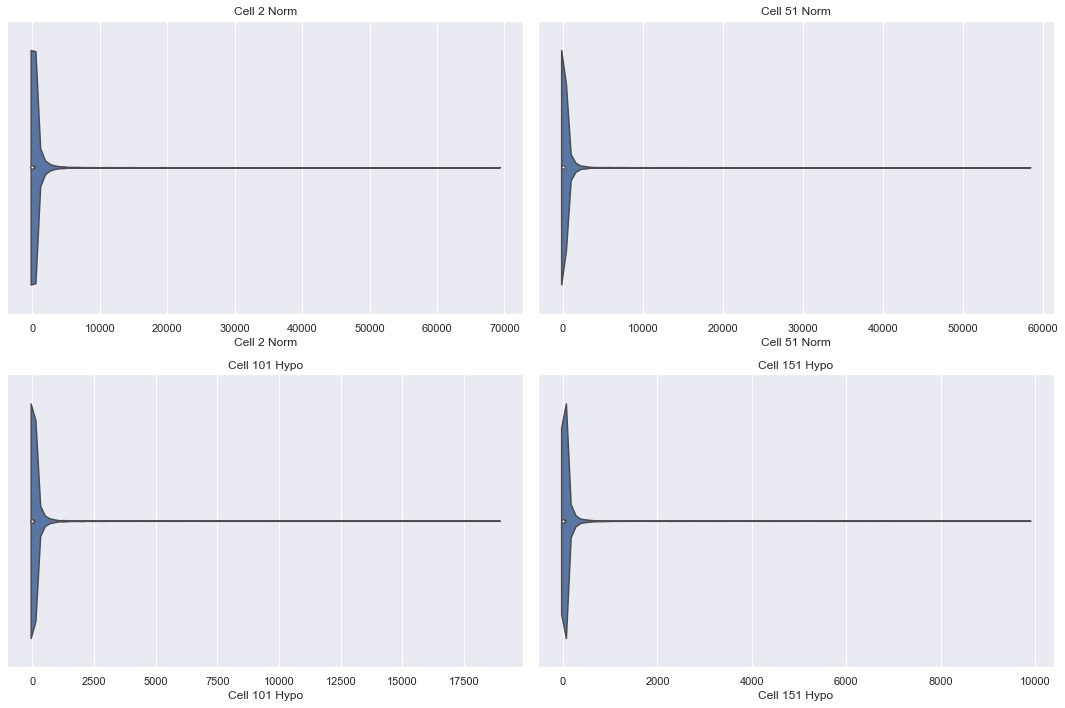

In [110]:

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

sns.violinplot(x=df2_unfilt[cnames1[1]], ax=axes[0, 0])
axes[0, 0].set_title(cnames1[1])

sns.violinplot(x=df2_unfilt[cnames1[50]], ax=axes[0, 1])
axes[0, 1].set_title(cnames1[50])

sns.violinplot(x=df2_unfilt[cnames1[100]], ax=axes[1, 0])
axes[1, 0].set_title(cnames1[100])

sns.violinplot(x=df2_unfilt[cnames1[150]], ax=axes[1, 1])
axes[1, 1].set_title(cnames1[150])

plt.tight_layout()
plt.show()


Density and Distribution: The plot shows a very high density of values near zero, indicated by the wide portion of the violin at the left side of the plot. This suggests that a majority of the data points are close to zero.

Range of Data: The long tail extending to the right indicates the presence of some values that are significantly higher than the rest. However, these higher values are relatively rare compared to the majority of the data.

Skewness: The plot is highly skewed to the right (as we already saw), meaning that there are a few extremely high values.

Outliers: The presence of a long tail could also indicate outliers or a long-tailed distribution where extreme values are present but not frequent. 

It seems the data is sparse. 



[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

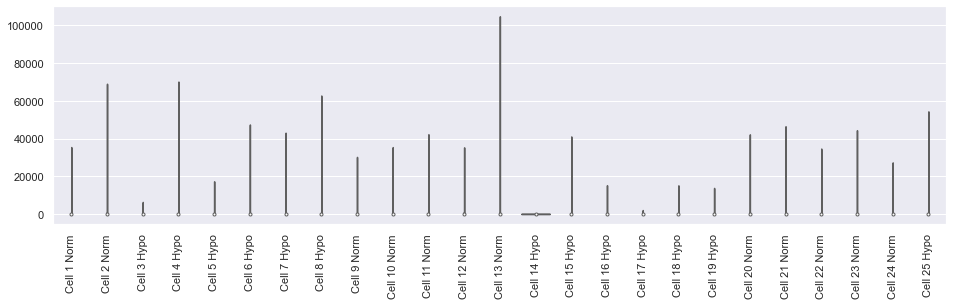

In [112]:
df_small = df2_unfilt.iloc[:, :25]
plt.figure(figsize=(16,4))
plot=sns.violinplot(data=df_small,palette="Set3",cut=0)
plt.setp(plot.get_xticklabels(), rotation=90)

We see that the range of values varies a lot from cell to cell, we plotted this to confirm our previous observation on more cells.

In [113]:
Q1 = df2_unfilt.quantile(0.25)
Q3 = df2_unfilt.quantile(0.75)
IQR = Q3 - Q1

df2_noOut = df2_unfilt[~((df2_unfilt < (Q1 - 1.5 * IQR)) |(df2_unfilt > (Q3 + 1.5 * IQR))).any(axis=1)]
df2_noOut.shape

(10815, 243)

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

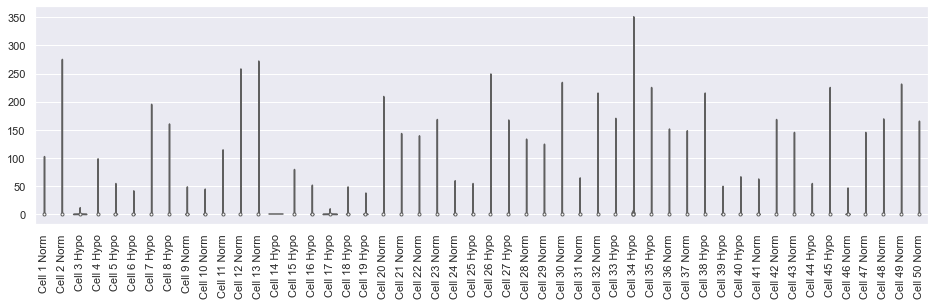

In [121]:
df2_noOut_small = df2_noOut.iloc[:, :50]
plt.figure(figsize=(16,4))
plot=sns.violinplot(data=df2_noOut_small,palette="Set3",cut=0)
plt.setp(plot.get_xticklabels(), rotation=90)

[29.060170892188808, 26.375803364082593, 50.42219295095526, 39.962261084335715, 40.831761136535434, 63.23072175896631, 26.321572538057914, 38.16336782098296, 71.1522146807669, 56.09724027024084, 48.99814039787873, 18.464775901153637, 47.15195689494234, 120.05593935544216, 33.99427128862153, 30.088231341030692, 22.286514610762975, 32.3921796727025, 38.75514237474577, 28.75570474961464, 31.127814981546333, 27.7243909375453, 29.148368072000252, 57.96588411901668, 36.200031752886005, 31.916505070774285, 28.849458624684896, 26.591278048758557, 31.005757883624007, 23.96877960582696, 65.75883126384987, 32.81420818258468, 37.862153037163516, 16.33822134075528, 37.031403931895355, 24.588248881976064, 26.540459898858327, 33.74323287097885, 24.719083908680908, 36.34765567523466, 43.81950268488599, 22.547359217928758, 38.00948983833193, 52.87075001506269, 28.831690939327846, 41.27143769895153, 23.900651442148476, 69.1193979984549, 23.274249122692947, 23.07242432362229, 40.34033497278627, 24.723445

Text(0.5, 0, 'Skewness of single cells expression profiles - original df')

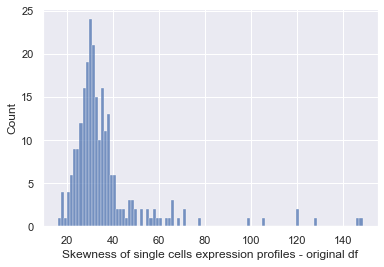

In [123]:
from scipy.stats import kurtosis, skew
colN = np.shape(df2_unfilt)[1]
df_skew_cells = []
for i in range(colN) :     
     v_df = df2_unfilt[cnames1[i]]
     df_skew_cells += [skew(v_df)]   
print(df_skew_cells)
sns.histplot(df_skew_cells,bins=100)
plt.xlabel('Skewness of single cells expression profiles - original df')

Text(0.5, 0, 'Kurtosis of single cells expression profiles - original df')

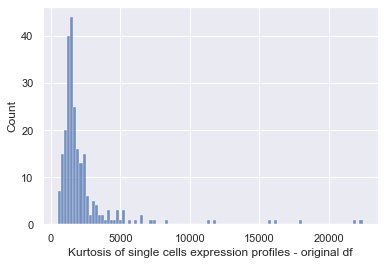

In [125]:
df_kurt_cells = []
for i in range(colN) :     
     v_df = df2_unfilt[cnames1[i]]
     df_kurt_cells += [kurtosis(v_df)]   
df_kurt_cells
sns.histplot(df_kurt_cells,bins=100)
plt.xlabel('Kurtosis of single cells expression profiles - original df')

In [127]:
xnorm = np.random.normal(0, 2, 10000000)   

print( "Excess kurtosis of normal distribution: ",  kurtosis(xnorm) )
print( "Skewness of normal distribution: ", skew(xnorm) )

Excess kurtosis of normal distribution:  -0.00045696062528532977
Skewness of normal distribution:  -0.000977452229828326


Since the values that we got for our datasets are much higher, we concluded that the distributions are highly non normal with heavy tails.

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

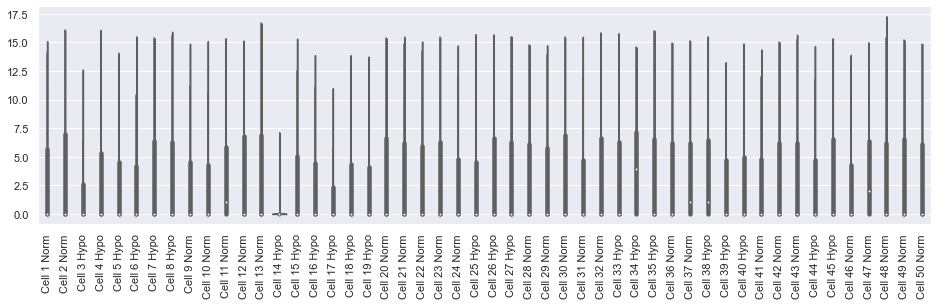

In [128]:
df2_unfilt_1 = df2_unfilt + 1
df2_unfilt_log2 = df2_unfilt_1.apply(np.log2)
df2_unfilt_log2_small = df2_unfilt_log2.iloc[:, :50]
np.shape(df2_unfilt_log2_small)
plt.figure(figsize=(16,4))
plot=sns.violinplot(data=df2_unfilt_log2_small,palette="Set3",cut=0)
plt.setp(plot.get_xticklabels(), rotation=90)

We applied a log2 transformation to the dataset, getting the following benefits:

1. Reduces Skewness

    Positive skewness means that the data has a long tail on the right side. This can distort statistical analyses and models, as many statistical methods assume normality (or at least less skewed distributions). A log2 transformation compresses the range of the data, bringing the values closer together, and reducing the impact of the tail. This results in a more symmetric distribution that is easier to work with.

2. Stabilizes Variance

    In datasets with high skewness, the variance can be high and non-constant. This can lead to heteroscedasticity in regression models, violating the assumption of constant variance of the errors. The log2 transformation helps to stabilize the variance across the range of data, making it more uniform. This is especially useful in models where constant variance is assumed.

3. Improves Linearity

    Many statistical techniques and machine learning models, such as linear regression, assume linear relationships between variables. In the presence of skewness, these relationships can appear non-linear. Applying a log2 transformation can help linearize relationships, making it easier to fit and interpret models.

4. Mitigates Influence of Outliers

    Outliers can disproportionately affect the analysis and results. A log2 transformation reduces the influence of large outliers by compressing the scale of large values. This makes the dataset more robust and reduces the undue influence of extreme values.


Each single cell was sequenced independently, so there might be need of normalizing the data between cells. Let's plot the gene expression distributions for each cell, and compare them.

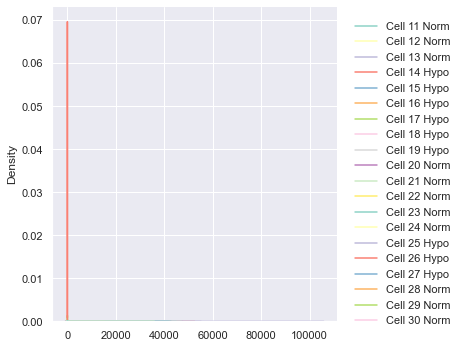

In [35]:
df2_small = df2_unfilt.iloc[:, 10:30]  
sns.displot(data=df2_small,palette="Set3",kind="kde", bw_adjust=2)

The data are clearly not normalized, and we need to preform the normalization before building a classifier.

In [130]:
duplicate_rows_df2 = df2_unfilt[df2_unfilt.duplicated(keep=False)]
print("number of duplicate rows: ", duplicate_rows_df2.shape)

number of duplicate rows:  (89, 243)


We see that we have some duplicate rows and we proceed by dropping them from the dataframe

In [131]:
df2_noDup = df2_unfilt.drop_duplicates()
df2_noDup.count()

Cell 1 Norm      23342
Cell 2 Norm      23342
Cell 3 Hypo      23342
Cell 4 Hypo      23342
Cell 5 Hypo      23342
                 ...  
Cell 239 Norm    23342
Cell 240 Norm    23342
Cell 241 Hypo    23342
Cell 242 Norm    23342
Cell 243 Norm    23342
Length: 243, dtype: int64

Number of cells included:  (243, 243)
Average correlation of expression profiles between cells:  0.4992953213403934
Min. correlation of expression profiles between cells:  -0.0014093573192132602


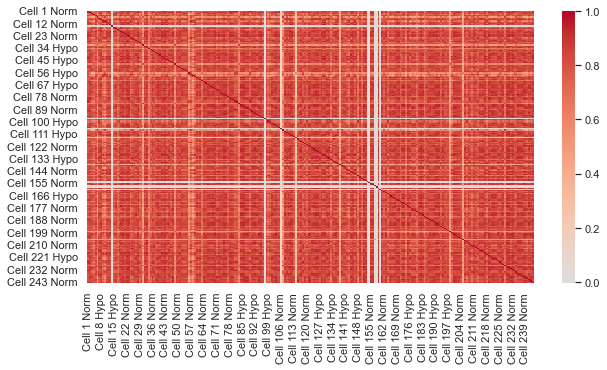

In [132]:
plt.figure(figsize=(10,5))
c2= df2_unfilt.corr()
midpoint = (c2.values.max() - c2.values.min()) /2 + c2.values.min()
sns.heatmap(c2,cmap='coolwarm', center=0 )
print("Number of cells included: ", np.shape(c2))
print("Average correlation of expression profiles between cells: ", midpoint)
print("Min. correlation of expression profiles between cells: ", c2.values.min())

In both datasets we have an avarage correlation of expresion profiles between cells of ~0.5.

Text(0.5, 0, 'Correlation between cells expression profiles')

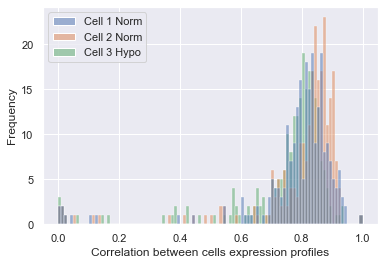

In [133]:
c2_small=c2.iloc[:,:3]
sns.histplot(c2_small,bins=100)
plt.ylabel('Frequency')
plt.xlabel('Correlation between cells expression profiles')

We expect the correlation between the gene expression profiles of the the single cells to be fairly high. Indeed it is ~0.5.

Some genes will be characteristic of some cells. For example in our case we expect some genes to be expressed at high levels only in cells cultured in conditions of low oxygen (hypoxia), or viceversa. However, most of the low and/or high expressed genes will tend to be generally similar. Several genes will have a high expression across cells as they are house keeping genes needed for the basic functioning of the cell. Some genes will have low expression across cells as they are less or not essential for the normal functioning, so they will have low or no expression across cells and will only be expressed in specific circumstances.


Are there some cells which are not correlated with the others? 

Looking at the heat map, we see some cells are completely uncorrelated, indeed there are many "white" lines.



We explore the distributions of gene expression for these cells.

As we can see from the violin plots, it is true that some of the uncorrelated cells have all zero values.

Number of cells included:  (2000, 2000)
Average correlation of expression profiles between cells:  0.41142773017328615
Min. correlation of expression profiles between cells:  -0.17714453965342783
             Gene 1    Gene 2    Gene 3    Gene 4    Gene 5    Gene 6  \
Gene 1     1.000000  0.058698  0.168118  0.209294 -0.041332  0.100043   
Gene 2     0.058698  1.000000 -0.031545  0.073023  0.052027  0.077980   
Gene 3     0.168118 -0.031545  1.000000  0.082945  0.215462  0.199874   
Gene 4     0.209294  0.073023  0.082945  1.000000  0.264348  0.125035   
Gene 5    -0.041332  0.052027  0.215462  0.264348  1.000000  0.236595   
...             ...       ...       ...       ...       ...       ...   
Gene 1996  0.065135  0.074679  0.056922  0.100855 -0.052827  0.077747   
Gene 1997  0.077925  0.042095 -0.014740  0.108075  0.148175  0.636164   
Gene 1998 -0.016106 -0.022725  0.002401  0.103006 -0.032756 -0.003572   
Gene 1999 -0.022005 -0.031048  0.038128 -0.048208 -0.044754 -0.060876   
G

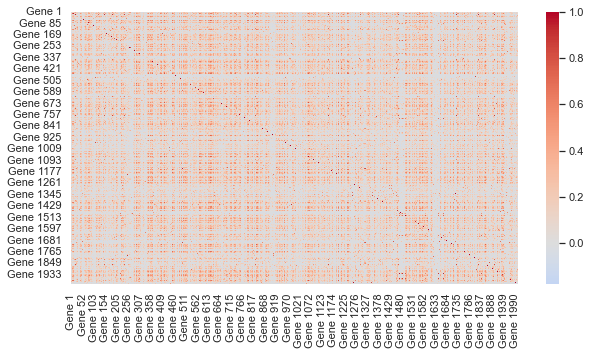

In [135]:
plt.figure(figsize=(10,5))
c2 = df2_unfilt.transpose().iloc[:,:2000]
c2 = c2.corr()
midpoint = (c2.values.max() - c2.values.min()) /2 + c2.values.min()
sns.heatmap(c2,cmap='coolwarm', center=0 )
print("Number of cells included: ", np.shape(c2))
print("Average correlation of expression profiles between cells: ", midpoint)
print("Min. correlation of expression profiles between cells: ", c2.values.min())
print(c2)



The genes are correlated as we can see from the average correlation of expression profiles between cells. Indeed rows representing samples under similar biological conditions might often be correlated and therefore hypoxic cells can be correlated between each other as well as normal cells 

Highly correlated rows can introduce redundancy in the dataset, which might affect the performance and efficiency of machine learning models. In order to prevent this, we can choose one of the following strategies:

- Clustering: Group similar rows to reduce redundancy.
- Dimensionality Reduction: Apply techniques like PCA to reduce the number of features while retaining most of the variability.

<h3><b>Clustering<b><h3>

<p><b>First, we perform hierarchical clustering, to see how the data points are interconnected. Since we are trying to perform binary classification, we will check after which number of clusters the performance drops. If the optimal number of clusters is 2, then we will also try k-means with k=2 as a classifier.</b></p>


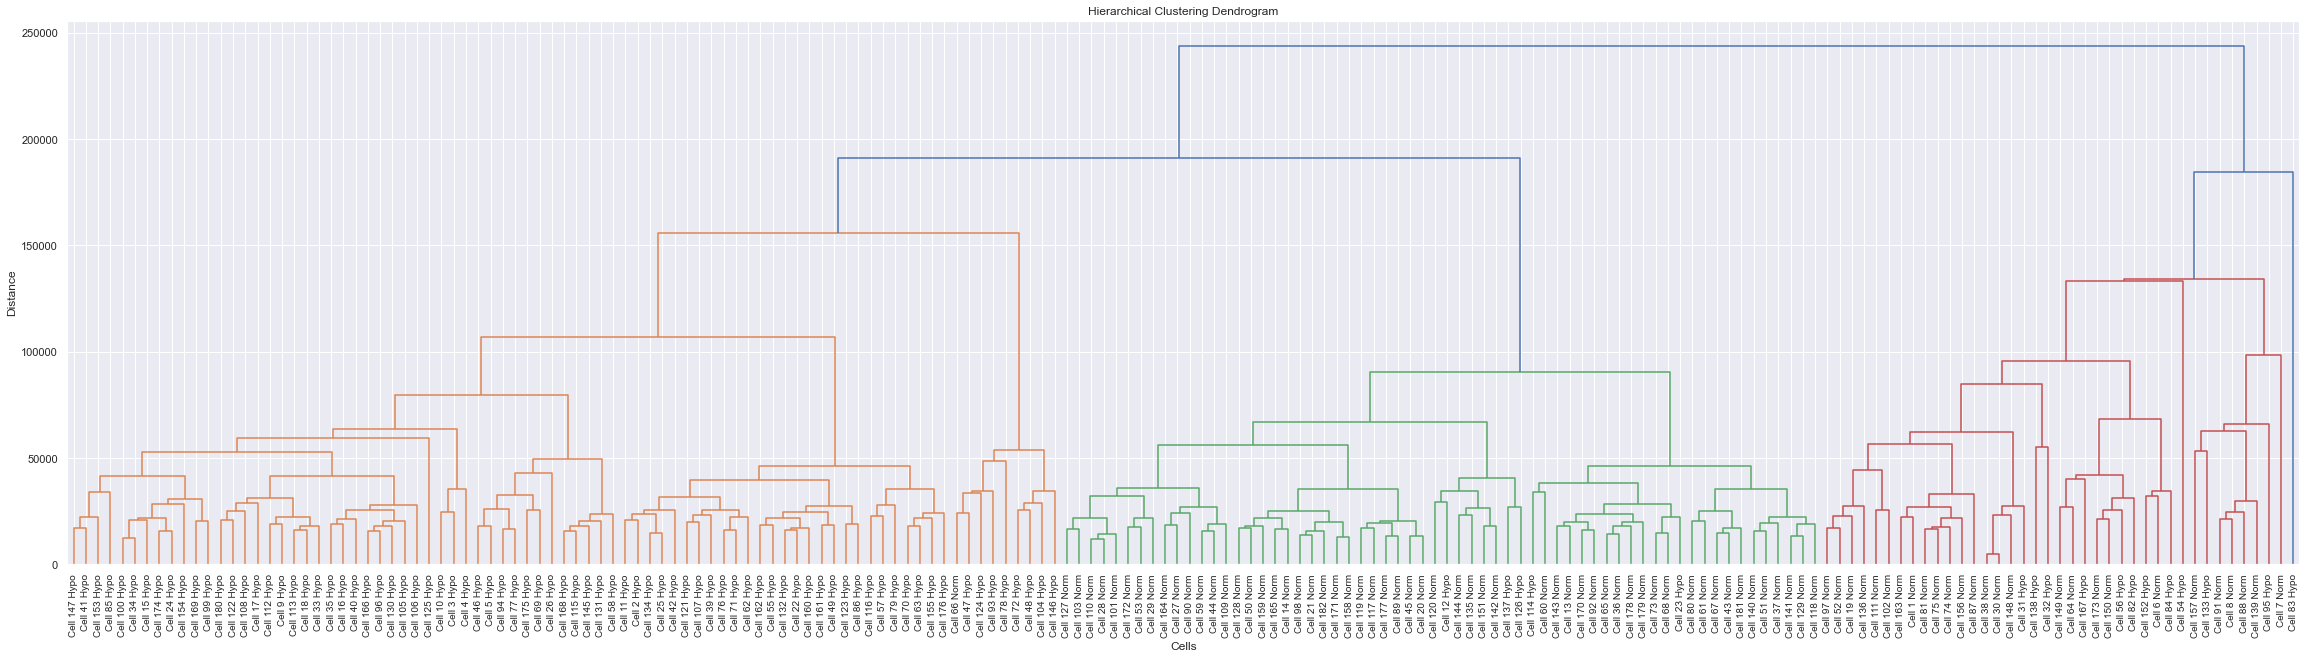

In [144]:


linked = linkage(df2_filt_norm.T, method='ward')


plt.figure(figsize=(40, 10)) 
dendrogram(linked,
           orientation='top',
           labels=df2_filt_norm.columns,
           distance_sort='descending',
           show_leaf_counts=True,
           leaf_font_size=10,
           )
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Cells')
plt.ylabel('Distance')
plt.show()

We see that there seem to be three distinct clusters. Before running k-means, we apply the elbow method to find the ideal number of clusters, to see if it aligns with the dendogram:

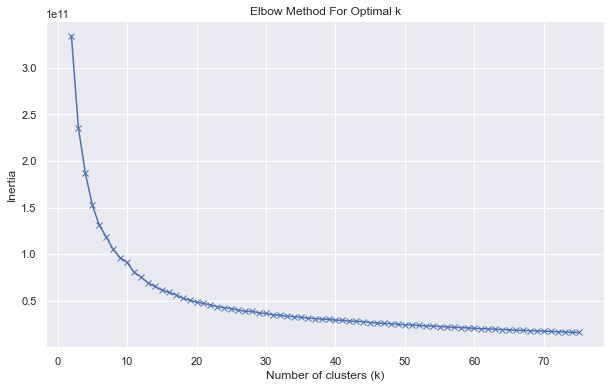

Optimal number of clusters: 3


In [148]:
from sklearn.cluster import KMeans


def optimal_clusters(X):
    inertia = []
    K = range(2, 76)  

    vals = X.values
    for k in K:
        kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42)
        kmeans.fit(vals)
        inertia.append(kmeans.inertia_)

    first_derivative = np.diff(inertia)
    second_derivative = np.diff(first_derivative)

    if len(second_derivative) > 0:
        elbow_point = K[np.argmax(second_derivative) + 1]
    else:
        elbow_point = K[0]
        
        
    plt.figure(figsize=(10, 6))
    plt.plot(K, inertia, 'bx-')
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Inertia')
    plt.title('Elbow Method For Optimal k')
    plt.show(), 
    print(f"Optimal number of clusters: {elbow_point}")

optimal_clusters(df2_filt_norm)

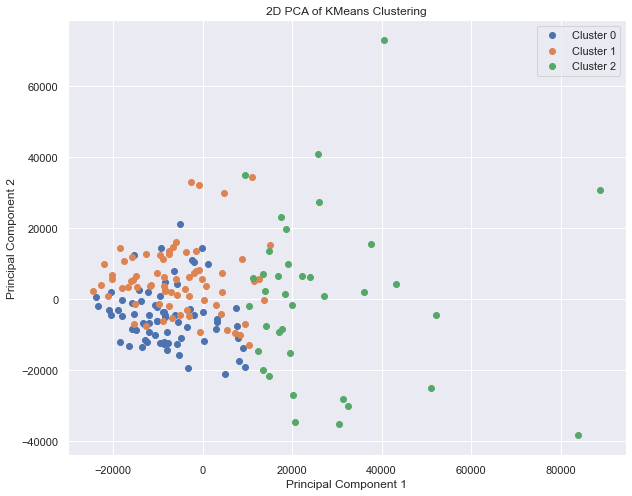

(array([2, 1, 1, 0, 2, 2, 2, 2, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1,
        0, 1, 1, 2, 0, 0, 0, 2, 2, 2, 1, 1, 1, 0, 0, 2, 1, 1, 1, 1, 0, 0,
        0, 1, 1, 1, 1, 0, 0, 0, 0, 2, 1, 2, 1, 1, 0, 0, 0, 1, 1, 2, 0, 0,
        0, 0, 2, 1, 1, 2, 0, 2, 0, 1, 1, 2, 1, 0, 0, 2, 2, 2, 1, 1, 0, 2,
        0, 0, 2, 0, 2, 1, 2, 1, 0, 0, 1, 1, 0, 2, 0, 1, 1, 1, 1, 1, 0, 0,
        2, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1,
        2, 1, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 1, 2, 1, 2, 2, 2, 0, 2, 1, 1,
        1, 0, 2, 0, 0, 1, 1, 1, 2, 0, 0, 1, 2, 1, 1, 0, 0, 0, 2, 1, 1, 1,
        0, 0, 0, 1, 0, 0], dtype=int32),
               Cell  Cluster
 0      Cell 1 Norm        2
 1      Cell 2 Hypo        1
 2      Cell 3 Hypo        1
 3      Cell 4 Hypo        0
 4      Cell 5 Hypo        2
 ..             ...      ...
 177  Cell 178 Norm        0
 178  Cell 179 Norm        0
 179  Cell 180 Hypo        1
 180  Cell 181 Norm        0
 181  Cell 182 Norm        0
 
 [182 rows x 2 co

In [178]:
from sklearn.decomposition import PCA

def K_Means_and_2D(k, X):

    cell_identifiers = X.columns.tolist()

    vals = X.T.values
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42)
    clusters = kmeans.fit_predict(vals)
    pca = PCA(n_components=2)
    vals_pca = pca.fit_transform(vals)
    cluster_labels = kmeans.labels_


    # Dataframe for plotting 
    df_pca = pd.DataFrame(data=vals_pca, columns=['Principal Component 1', 'Principal Component 2'])
    df_pca['Cluster'] = clusters

    cluster_assignments = pd.DataFrame({
        'Cell': cell_identifiers,
        'Cluster': clusters
    })

    # 2D Rep. of Data
    plt.figure(figsize=(10, 8))
    for cluster in np.unique(clusters):
        plt.scatter(df_pca[df_pca['Cluster'] == cluster]['Principal Component 1'],
                    df_pca[df_pca['Cluster'] == cluster]['Principal Component 2'],
                    label=f'Cluster {cluster}')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.title('2D PCA of KMeans Clustering')
    plt.legend()
    plt.show()

    return cluster_labels, cluster_assignments

K_Means_and_2D(3, df2_filt_norm)

It is not surprising that 3 clusters are not able to cluster the cells well (since we should be able to catetegorise them by hypoxic and normoxic). Let us see what results we obtain when we do 2 clusters: 

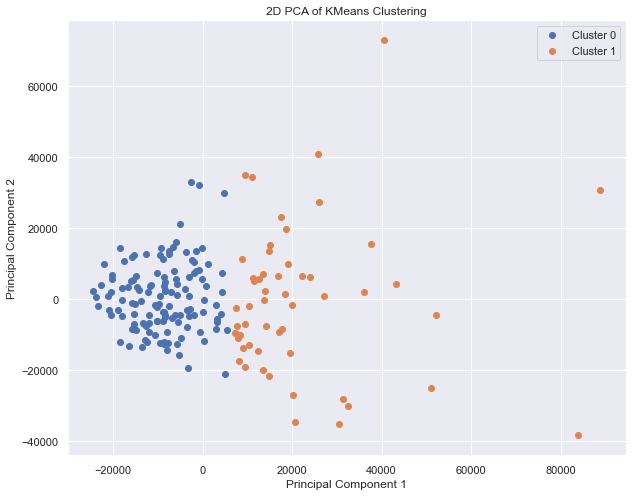

In [181]:
cluster_labels, identification = K_Means_and_2D(2, df2_filt_norm)

In [183]:
cluster_labels, identification

(array([1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1,
        0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0,
        0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1,
        0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0,
        1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0,
        0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0,
        0, 0, 0, 0, 0, 0], dtype=int32),
               Cell  Cluster
 0      Cell 1 Norm        1
 1      Cell 2 Hypo        0
 2      Cell 3 Hypo        0
 3      Cell 4 Hypo        0
 4      Cell 5 Hypo        1
 ..             ...      ...
 177  Cell 178 Norm        0
 178  Cell 179 Norm        0
 179  Cell 180 Hypo        0
 180  Cell 181 Norm        0
 181  Cell 182 Norm        0
 
 [182 rows x 2 co

In [180]:
def check_accuracy(cluster_labels, df2_filt_norm):
    acc = 0
    norm = 0
    hypo = 0
    for i in range(len(cluster_labels)):
        if cluster_labels[i] == 1 and "Norm" in df2_filt_norm.columns[i]:
            acc += 1
            norm += 1
        if cluster_labels[i] == 0 and "Hypo" in df2_filt_norm.columns[i]:
            acc += 1
            hypo += 1
    acc = acc / len(cluster_labels)
    return max(acc, 1-acc), norm, hypo 


acc, norm, hypo = check_accuracy(cluster_labels, df2_filt_norm) 

print("Accuracy: ", round(acc, 2))

Accuracy:  0.52


The data seems to be too complex to be separated into 2 clusters. 

### Logistic Regression

In [191]:
from sklearn.model_selection import cross_val_score

In [207]:

X = df2_filt_norm.T
Y = pd.Series(np.zeros(len(df2_filt_norm.columns)))
for i in range(len(df2_filt_norm.columns)):
    if 'Hypo' in df2_filt_norm.columns[i]:
        Y[i] = 1

X_train, X_test, Y_train, Y_test = train_test_split(X,Y,train_size = 0.33)

In [208]:


param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']
}

grid = GridSearchCV(LogisticRegression(random_state=42, max_iter=500), param_grid, cv=5)
grid.fit(X_train, Y_train)

best_params = grid.best_params_
print("Best Parameters:", best_params)


best_model = LogisticRegression(**best_params, random_state=42, max_iter=500)

cv_scores = cross_val_score(best_model, X_train, Y_train, cv=5, scoring='accuracy')
print("Cross-Validation Accuracy Scores:", cv_scores)
print("Mean CV Accuracy with Best Parameters:", cv_scores.mean() * 100)



Best Parameters: {'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}
Cross-Validation Accuracy Scores: [0.91666667 1.         1.         1.         0.91666667]
Mean CV Accuracy with Best Parameters: 96.66666666666666


### XGBoost

In [209]:

xgc1 = xgb.XGBClassifier(objective='binary:logistic', max_depth=5, n_estimators=300, seed=42, reg_alpha=1.0)

xgc1.fit(X_train, Y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [211]:

cv_scores = cross_val_score(xgc1, X_test, Y_test, cv=5, scoring='accuracy')
print("Cross-Validation Accuracy Scores:", cv_scores)
print("Mean CV Accuracy with Best Parameters:", cv_scores.mean() * 100)

Cross-Validation Accuracy Scores: [0.88 1.   1.   1.   1.  ]
Mean CV Accuracy with Best Parameters: 97.6


<h1><b>Multilayer Perceptron</b></h1>

Now we try to build a predictor using a supervised machine learning technique. In particular we build a multilayer perceptron.

First of all we define all the functions that we will need later

In [214]:
def Pca(df, components):
    
    array = df.to_numpy()
  
    pca = PCA(n_components=components)
    pca.fit(array)

    array_PCA = pca.transform(array)


    df_PCA = pd.DataFrame(array_PCA)
    df_PCA.index = df.index
    
    return pca, df_PCA

In [215]:
def elbow_plot(pca):

    explained_variance_ratio = pca.explained_variance_ratio_

    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, marker='o', linestyle='-')
    plt.xlabel('Number of Components')
    plt.ylabel('Explained Variance Ratio')
    plt.title('Explained Variance Ratio vs. Number of Components')
    plt.grid(True)

    plt.show()



In [216]:
def total_variance_explained(pca):   
    explained_variance_ratio = pca.explained_variance_ratio_
    total_variance_explained = sum(explained_variance_ratio)
    print(total_variance_explained)

In [217]:
class MLP(torch.nn.Module):
    def __init__(self, num_features, num_classes):
        
        super().__init__()
        
        self.all_layers = torch.nn.Sequential(

            #1st hidden layer
            torch.nn.Linear(num_features, 64),
            torch.nn.ReLU(),
            torch.nn.Dropout(p=0.5),
            
            #2nd hideen layer
            torch.nn.Linear(64, 64),
            torch.nn.ReLU(),
            torch.nn.Dropout(p=0.5),

            #3rd hideen layer
            torch.nn.Linear(64, 64),
            torch.nn.ReLU(),
            torch.nn.Dropout(p=0.5),

            #output layer
            torch.nn.Linear(64, num_classes)
            
        )
    
    def forward(self, x):
        logits = self.all_layers(x)
        return logits

In [218]:

def Compute_Accuracy(model, X, y):

    model = model.eval()
    correct = 0
    total_examples = 0
    
       
    with torch.inference_mode():
        logits = model(X)
    predictions = torch.argmax(logits, dim=1)

    compare = y == predictions       
    correct += torch.sum(compare)
    total_examples += len(compare)
    
    return correct / total_examples

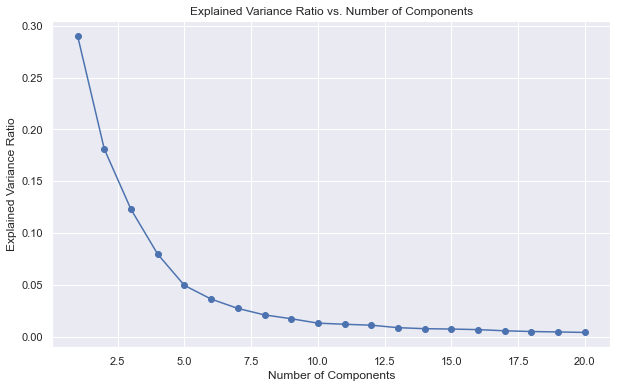

0.9129870166266784


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
Cell 1 Norm,12484.174027,-14826.664867,7360.236998,3157.989001,3399.245417,-3325.732676,-8234.448176,-4364.244234,-604.098027,2300.992333,1277.325165,810.478552,1635.613851,668.349733,2777.332286,-3781.096686,-717.776270,-793.221239,1011.888266,-2097.039424
Cell 2 Hypo,-12606.976255,12610.742558,-3858.152337,-252.437605,-5709.942318,-6784.522619,4736.948453,-6626.167901,1339.344408,3841.417803,-1882.774137,2175.129144,907.391110,-883.705546,2438.675378,2273.492007,4464.642932,-2025.789532,-880.067274,-1430.080423
Cell 3 Hypo,-7012.948466,1899.037674,-4994.955154,8261.200592,-5328.775510,-12346.956166,-3518.935388,391.929677,6386.863333,-6924.004748,-10174.314781,7614.907311,1866.187269,133.690335,2069.802370,-3792.245709,4952.979253,693.525544,-1152.933855,-353.536756
Cell 4 Hypo,-5643.489317,4219.796233,5613.389157,12015.035519,-8790.456350,-9463.983657,-12167.275708,-3484.640520,1265.274253,2307.857395,-5266.138134,3778.814779,58.835193,-2992.190682,-3350.480213,-176.211877,-3388.255982,2775.876221,888.031212,1176.890826
Cell 5 Hypo,19036.152533,9662.303831,-15784.171632,-4727.878073,-752.644530,-820.273314,2546.483301,1675.765532,-4802.468964,-2030.178058,-2946.881318,2465.925634,3560.933764,-1365.157971,-1346.022503,3077.493661,-170.931789,377.908413,-472.789657,1363.142208
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Cell 178 Norm,-17918.561428,-4790.049580,11790.599425,-754.813984,3484.348528,-452.380693,3030.061009,1091.308186,952.304910,-1283.264117,-1198.717342,-2621.735211,-243.003849,887.420012,-976.826644,-80.165396,-696.944172,1300.320158,1583.892670,-687.576110
Cell 179 Norm,-18370.891611,-12095.117570,10508.713512,2045.930368,6996.574822,-2398.954771,48.687234,-2404.142332,-4479.519660,-130.343147,-421.201468,3533.754291,-1185.920354,1498.720492,5047.564664,-1917.585655,2898.571460,2046.184170,-4082.566095,4009.082946
Cell 180 Hypo,-648.980786,-9237.045458,-13170.990649,4496.954545,12228.706508,-614.167061,-3620.992455,-754.501170,5724.644584,-614.479210,-1337.590820,898.105574,42.772356,598.424110,3871.149823,-1131.632959,-1075.164481,-1757.977618,-1232.741761,-2112.972106
Cell 181 Norm,-12029.748024,-9483.044988,5149.826571,4178.120097,15353.830597,-7929.438786,-4287.321198,-1126.566246,-1512.961960,859.824151,-503.414795,-1112.696097,-2128.806712,-3054.976778,709.664176,-2286.844602,-2354.518129,-433.416279,2082.066439,-3486.084336


In [219]:
curr_num_comp = 20
curr_df = df2_filt_norm.transpose()
pca, df_PCA = Pca(curr_df, curr_num_comp)
elbow_plot(pca)
total_variance_explained(pca)
df_PCA


We perform PCA to reduce the dimensionality of the data so that the dataframe is manageable by the MLP. We decided to use 20 principal components as the explained variance is more than enough and the elbow plot shows us that we are getting significantly diminishing returns after 5 components already.

In [220]:

if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"Using CUDA: {torch.cuda.get_device_name(0)}")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using MPS (Apple Silicon GPU)")
else:
    device = torch.device("cpu")
    print("Using CPU")

data = df_PCA
data['Label'] = data.index.to_series().apply(lambda x: 1 if "Hypo" in x else 0)

X = data.drop(columns="Label").values
y = data['Label'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)

print(np.bincount(y_train))
print(np.bincount(y_test))

X_train = torch.tensor(X_train, dtype=torch.float32, device = device)
X_test = torch.tensor(X_test, dtype=torch.float32, device = device)
y_train = torch.tensor(y_train, dtype=torch.int64, device = device)
y_test = torch.tensor(y_test, dtype=torch.int64, device = device)

Using MPS (Apple Silicon GPU)
[68 77]
[17 20]


We now move everything to the GPU for faster running times, we extract the lables from the dataset and we create a training and testing dataset. 
Now the only thing left to do is to train the model

In [221]:

import torch.nn.functional as F

torch.manual_seed(23)
model1 = MLP(num_features=curr_num_comp, num_classes=2)
model1.to(device)
optimizer = torch.optim.Adam(model1.parameters(), lr=0.005)

num_epochs = 40

for epoch in range(num_epochs):

    model1 = model1.train()
    logits = model1(X_train)
    loss = F.cross_entropy(logits, y_train)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    train_acc = Compute_Accuracy(model1, X_train, y_train)
    val_acc = Compute_Accuracy(model1, X_test, y_test)

    print(f"loss : {loss}, train accuracy : {train_acc}, test_accuracy : {val_acc}, precision : {precision_score(y_test.cpu(), torch.argmax(model1(X_test), dim=1).cpu())}, recall : {recall_score(y_test.cpu(), torch.argmax(model1(X_test), dim=1).cpu())}")
    

loss : 238.38784790039062, train accuracy : 0.8206896781921387, test_accuracy : 0.7297297120094299, precision : 0.8571428571428571, recall : 0.6
loss : 162.938720703125, train accuracy : 0.834482729434967, test_accuracy : 0.7567567825317383, precision : 0.9230769230769231, recall : 0.6
loss : 127.4013442993164, train accuracy : 0.9034482836723328, test_accuracy : 0.8108108043670654, precision : 0.9333333333333333, recall : 0.7
loss : 86.7537841796875, train accuracy : 0.931034505367279, test_accuracy : 0.8108108043670654, precision : 0.8095238095238095, recall : 0.85
loss : 67.6877670288086, train accuracy : 0.9448275566101074, test_accuracy : 0.837837815284729, precision : 0.8181818181818182, recall : 0.9
loss : 73.69992065429688, train accuracy : 0.9586206674575806, test_accuracy : 0.8648648858070374, precision : 0.8571428571428571, recall : 0.9
loss : 99.3182144165039, train accuracy : 0.9793103337287903, test_accuracy : 0.8918918967247009, precision : 0.9, recall : 0.9
loss : 42.20

To conclude, we applied all the models and evaluated them using a test data set, which we are not able to share because of an NDA.